# 注意力评分函数
[10.2](https://zh-v2.d2l.ai/chapter_attention-mechanisms/nadaraya-waston.html#equation-eq-nadaraya-watson-gaussian)节使用了高斯核来对查询和键之间的关系建模。 [(10.2.6)](https://zh-v2.d2l.ai/chapter_attention-mechanisms/nadaraya-waston.html#equation-eq-nadaraya-watson-gaussian)中的 高斯核指数部分可以视为注意力评分函数（attention scoring function）， 简称评分函数（scoring function）， 然后把这个函数的输出结果输入到softmax函数中进行运算。 通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。 最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现 [图10.1.3](https://zh-v2.d2l.ai/chapter_attention-mechanisms/attention-cues.html#fig-qkv)中的注意力机制框架。 下图说明了 如何将注意力汇聚的输出计算成为值的加权和， 其中
表示注意力评分函数。 由于注意力权重是概率分布， 因此加权和其本质上是加权平均值。
<center>
    <figure>
        <img src="https://zh-v2.d2l.ai/_images/attention-output.svg" alt="attention-output" />
            <figcaption> 图1：计算注意力汇聚的输出为值的加权和</figcaption>
    </figure>
</center>

用数学语言描述，假设有一个查询$\mathbf{q}\in\mathbb{R}^q$和$m$ 个“键－值”对$(\mathbf{k}_1,\mathbf{v}_1),\ldots,(\mathbf{k}_m,\mathbf{v}_m)$， 其中$\mathbf{k}_i\in\mathbb{R}^k,\mathbf{v}_i\in\mathbb{R}^v$。 注意力汇聚函数$f$就被表示成值的加权和：
$$
f(\mathbf{q},(\mathbf{k}_1,\mathbf{v}_1),\ldots,(\mathbf{k}_m,\mathbf{v}_m))=\sum_{i=1}^m\alpha(\mathbf{q},\mathbf{k}_i)\mathbf{v}_i\in\mathbb{R}^v
$$

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量） 是通过注意力评分函数$a$将两个向量映射成标量， 再经过softmax运算得到的：
$$
\alpha(\mathbf{q},\mathbf{k}_i)=\text{softmax}(a(\mathbf{q},\mathbf{k}_i))=\frac{\exp(a(\mathbf{q},\mathbf{k}_i))}{\sum_{j=1}^m\exp(a(\mathbf{q},\mathbf{k}_j))}\in\mathbb{R}
$$

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。 本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 掩蔽softmax操作
正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。 在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。 例如，为了在 [9.5](https://zh-v2.d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html#sec-machine-translation)节中高效处理小批量数据集， 某些文本序列被填充了没有意义的特殊词元。 为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）， 以便在计算softmax时过滤掉超出指定范围的位置。 下面的`masked_softmax`函数 实现了这样的**掩蔽softmax操作**（masked softmax operation）， 其中任何超出有效长度的位置都被掩蔽并置为0。

In [2]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了演示此函数是如何工作的， 考虑由两个$2\times 4$矩阵表示的样本， 这两个样本的有效长度分别为$2$和$3$。 经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4579, 0.5421, 0.0000, 0.0000],
         [0.5132, 0.4868, 0.0000, 0.0000]],

        [[0.3272, 0.3514, 0.3214, 0.0000],
         [0.3000, 0.4105, 0.2894, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2810, 0.4166, 0.3023, 0.0000]],

        [[0.4432, 0.5568, 0.0000, 0.0000],
         [0.3473, 0.1766, 0.2115, 0.2646]]])

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。 给定查询$\mathbf{q}\in\mathbb{R}^q$和 键$\mathbf{k}\in\mathbb{R}^k$， 加性注意力（additive attention）的评分函数为
$$
a(\mathbf{q},\mathbf{k})=\mathbf{w}_v^\top\tanh(\mathbf{W}_q\mathbf{q}+\mathbf{W}_k\mathbf{k})\in\mathbb{R}
$$

其中可学习的参数是$\mathbf{W}_q\in\mathbb{R}^{h\times q}$、$\mathbf{W}_k\in\mathbb{R}^{h\times k}$， 和$\mathbf{w}_v\in\mathbb{R}^h$。 将查询和键连结起来后输入到一个多层感知机（MLP）中， 感知机包含一个隐藏层，其隐藏单元数是一个超参数
。 通过使用$\tanh$作为激活函数，并且禁用偏置项。

下面来实现加性注意力。

In [5]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

用一个小例子来演示上面的AdditiveAttention类， 其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小）， 实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。 注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的， 所以注意力权重是均匀的，由指定的有效长度决定。

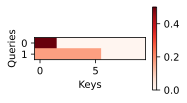

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 缩放点积注意力
使用点积可以得到计算效率更高的评分函数， 但是点积操作要求查询和键具有相同的长度$d$。 假设查询和键的所有元素都是独立的随机变量， 并且都满足零均值和单位方差， 那么两个向量的点积的均值为$0$，方差为$d$。 为确保无论向量长度如何， 点积的方差在不考虑向量长度的情况下仍然是$1$， 我们再将点积除以$\sqrt{d}$， 则缩放点积注意力（scaled dot-product attention）评分函数为：
$$
a(\mathbf{q},\mathbf{k})=\mathbf{q}^\top\mathbf{k}/\sqrt{d}
$$

在实践中，我们通常从小批量的角度来考虑提高效率， 例如基于$n$个查询和$m$个键－值对计算注意力， 其中查询和键的长度为$d$，值的长度为$v$。 查询$\mathbf{Q}\in\mathbb{R}^{n\times d}$、 键$\mathbf{K}\in\mathbb{R}^{m\times d}$和 值$\mathbf{V}\in\mathbb{R}^{m\times v}$的缩放点积注意力是：
$$
\text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}}\right)\mathbf{V}\in\mathbb{R}^{n\times v}
$$

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。

In [8]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了演示上述的`DotProductAttention`类， 我们使用与先前加性注意力例子中相同的键、值和有效长度。 对于点积操作，我们令查询的特征维度与键的特征维度大小相同。

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素， 而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。

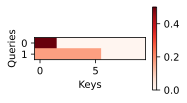

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')